In [1]:
import pandas as pd
import numpy as np
from random import randint
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [2]:
%%html
<style>
table {float:left}
</style>

Using the MNIST digit dataset.

Source: http://yann.lecun.com/exdb/mnist/

sklearn has nicely [imported](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits) it for us.

| Classes           | 10            |
|-------------------|---------------|
| Samples per class | ~180          |
| Samples total     | 1797          |
| Dimensionality    | 64            |
| Features          | integers 0-16 |

<class 'sklearn.datasets.base.Bunch'>
[1775, 1248, 1373, 817, 839, 183, 1406, 1627, 1766, 39]


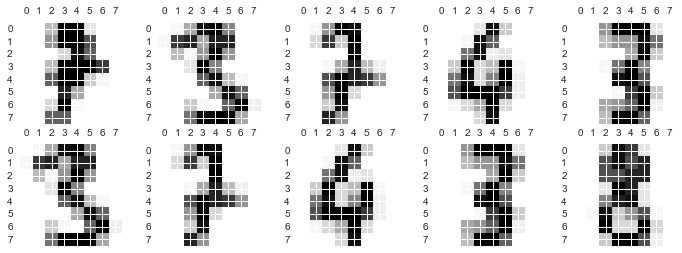

In [3]:
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)
print type(digits)

import random
digits_sample = random.sample(range(0,digits.images.shape[0]),10)
print digits_sample

#show sample digits
plt.rcParams['figure.figsize'] = (12, 4)
f, axarr = plt.subplots(2, 5)
for j in range(0,axarr.shape[1]):
    for i in range(0,axarr.shape[0]):
        axarr[i,j].matshow(digits.images[digits_sample[i+j]])
plt.show()

Multi Layer Feed-Forward Neural Network (in this case, 3 layers [input, 1 hidden, output])

Source: https://en.wikipedia.org/wiki/Feedforward_neural_network

Source2: http://neuralnetworksanddeeplearning.com/chap1.html

The structure is something like the below.

In our case, each image have a total of 8x8 = 64 pixels, so using 64 input neurons instead.
We can try using 15 hidden neurons.

<img src="http://neuralnetworksanddeeplearning.com/images/tikz12.png" style="width:500px;" />

10-digit multi-classification where probability for each digit's prediction node is

$$ f(w,X) = \dfrac{1}{1+e^{-(w \cdot X)}} $$

(Note: the weight vector "w" includes bias component as w0)

Loss function is a mean-square error(MSE).
$$ L = \dfrac{1}{2m}\sum_{i=1}^m \bigl\|\;f(x_i) - y_i\;\bigr\|^2 $$

For optimization methods, we will use "mini-batch stochastic gradient descent"

mini-batch & stochastic means we will sample n datapoints and compute an aggregate gradient to update the weights.

Update the weights "w" , iterate over each input vector j:

$$ w_i(t+1) = w_i(t) +(y_i - f(x_i)) \cdot x_{i,j} $$



The $ \| v \| $ just means the function applies over the length of vectors.

In [70]:
#make a flat 10 output with all zeros
Y = np.zeros((digits.target.shape[0],10))
for j in range(0,digits.target.shape[0]):
    Y[j][digits.target[j]] = 1

#make a row of 64 input features instead of 8x8
X = digits.images.reshape(digits.images.shape[0],digits.images.shape[1]*digits.images.shape[2])
Xb = np.insert(X,0,1,axis=1) #add bias input, always activated

In [57]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

8


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

In [55]:
X[0:3]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
         15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
          8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
          5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
          1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
          0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  12.,  13.,   5.,   0.,   0.,   0.,   0.,   0.,
         11.,  16.,   9.,   0.,   0.,   0.,   0.,   3.,  15.,  16.,   6.,
          0.,   0.,   0.,   7.,  15.,  16.,  16.,   2.,   0.,   0.,   0.,
          0.,   1.,  16.,  16.,   3.,   0.,   0.,   0.,   0.,   1.,  16.,
         16.,   6.,   0.,   0.,   0.,   0.,   1.,  16.,  16.,   6.,   0.,
          0.,   0.,   0.,   0.,  11.,  16.,  10.,   0.,   0.],
       [  0.,   0.,   0.,   4.,  15.,  12.,   0.,   0.,   0.,   0.,   3.,
         16.,  15.,  14.,   0.,   0.,   0.,   0.,   8.,  13.

In [4]:
def f_func(w,x):
    result = w.dot(x.transpose())
    return np.where(result>0,1,0)

def loss_func(f,y):
    return np.average(np.abs(f - y))

In [5]:
#initialize everything.
w = np.array([0.01 , 0.01, 0.01]) # including bias as weight (w0 in the first column)
Xb = np.insert(X,0,1,axis=1) #add bias input, always activated

#run till convergence
y_pred = f_func(w,Xb)
curr_loss = loss_func(y_pred,Y)
loss = []
loss.append(curr_loss)

for i in range(0,100):
    
    #iterate over each j input vector
    for j in range(0,Y.shape[0]): 
        y_pred[j] = f_func(w,Xb[j])
        w = w + (Y[j] - y_pred[j])*Xb[j]
    
    #evaluate aggregate loss function    
    y_pred = f_func(w,Xb)
    curr_loss = loss_func(y_pred,Y)
    loss.append(curr_loss)
    
    #stopping criterion
    if (i>10) and ((loss[-2] - curr_loss) < 10**-5): 
        print 'stop at {}'.format(i)
        break

print w
plt.figure()
plt.xlabel('no. of run')
plt.ylabel('loss function')
plt.title('Loss function minimization over time')
sns.tsplot(loss)

NameError: name 'X' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
cm_mat = confusion_matrix(Y,y_pred)
print cm_mat.T
df_temp = pd.DataFrame(cm_mat.flatten()[np.newaxis].T,columns = ['values'])
plt.figure(figsize = (6,4),dpi=600)
sns.heatmap(cm_mat.T, cbar=True ,annot=True, fmt=',.0f')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.title('confusion matrix')

In [ ]:
#plot decision boundary

plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y)

x_line = np.array([np.min(X[:, 0]),np.max(X[:, 0])]) #this is "x0"
y_line = -(w[0] + w[1]*x_line)/w[2] #plot y_line based on where it makes "x1" becomes zero
plt.plot(x_line,y_line)
plt.show()
print y_line